In [1]:
import shutil
from orcapod_plus import (
    Pod,
    Annotation,
    StreamInfo,
    Pipeline,
    store,
)
from pprint import pprint

# Pipeline

Borrowing from the simple example we used in the pipeline concepts review session ([definitions](https://enigma-brain.slack.com/files/U07GMLK82A0/F08QJP1F82Y/orcabridge_demo.pdf), [example](https://enigma-brain.slack.com/files/U07GMLK82A0/F08QTG3NX41/orcabridge_demo.pdf)), we'll define a style transfer chain of computation. First we'll need to define the `Pipeline`. You can think of pipelines as reusable, modular blocks that can be used on their own or assembled/combined to create a more complex computational pipeline via `PipelineJob` (see below).

> Note: Since these are more like computational "templates", the following are the node rules:
> - allowed:
>   - `Pod`
>   - `Mapper`
>   - `Curator`
> - not allowed:
>   - `Input`

`transfer_style` here is a `Pod` that simply takes 1 subject image and 1 painting style model to produce a result image that applies the painting style transfer.

In [2]:
transfer_style = Pod(
    annotation=Annotation(
        name="transfer_style",
        version="1.0.0",
        description="This pod applies an image style transfer.",
    ),
    image="example.server.com/user/transfer-style:1.0.0",
    command="python /run.py",
    input_stream={
        "subject": StreamInfo(path="/input/subject.png", match_pattern=".*\.png"),
        "style": StreamInfo(path="/input/style.t7", match_pattern=".*\.t7"),
    },
    output_dir="/output",
    output_stream={"result": StreamInfo(path="./result.png", match_pattern=".*\.png")},
    source_commit_url="https://github.com/user/transfer-style/tree/1.0.0",
    recommended_cpus=0.25,
    recommended_memory=1 << 30,
    required_gpu=None,
)

In [3]:
store.save_pod(pod=transfer_style)

`invert_image` here is just a `Pod` that inverts an image's colors e.g. increase contrast, make colorblind friendly, etc. Really just serving the purpose of demonstrating a multi-pod pipeline.

In [22]:
invert_image = Pod(
    annotation=Annotation(
        name="invert_image",
        version="0.0.1",
        description="This pod inverts the image colors.",
    ),
    image="example.server.com/user/invert-image:0.0.1",
    command="python /run.py",
    input_stream={"source": StreamInfo(path="/input/source.png", match_pattern=".*\.png")},
    output_dir="/output",
    output_stream={"result": StreamInfo(path="./result.png", match_pattern=".*\.png")},
    source_commit_url="https://github.com/user/invert-image/tree/0.0.1",
    recommended_cpus=0.1,
    recommended_memory=10 << 20,
    required_gpu=None,
)

In [23]:
store.save_pod(pod=invert_image)

Skip saving pod model since `1939246564aa830da5aedec147701fb2930775fdd3778bdc1b5cf67bd8ae2932` exists.


Here we define the `process_image` pipeline via a YAML spec. This could either be user-facing or what a GUI/Python API would produce from user interaction. It defines the user's intent as a `Pipeline`.

Similarly as other `orcapod` models, pipeline `annotation` is optional.

`definition` supports DOT syntax, however, style declaration (e.g. colors, shapes, formatting, font size, etc.) should not be included. It is meant only for the graph definition as opposed to how to draw it.

`metadata` is for `orcapod`-specific info per node. There are 2 modes for this: an inline definition or via `link` which is more succinct. Both are demonstrated below.
- inline definition: A node's annotation and spec can be defined directly.
- `link`: The user can reference a model that already exists in the store by specifying the model class (e.g. `pod`) and a `ModelID` for the `link`. As a review, `ModelID` is an enum on rust side which has 2 ways to specify: `Hash` via `hash` (model w/o annotation) or `Annotation` via `name` + `version` (model w/ annotation).

In [24]:
pipeline_input = f"""
class: pipeline
annotation:
  name: process_image
  version: 0.1.0
  description: This pipeline performs a style transfer + inverts the colors of an image.
definition: |
  transfer_style -> invert_image
metadata:
  transfer_style:
    spec:
      class: pod
      link:
        hash: {transfer_style.hash()}
  invert_image:
    annotation:
      name: invert_image
      version: 0.0.1
      description: This pod inverts the image colors.
    spec:
      class: pod
      image: example.server.com/user/invert-image:0.0.1
      command: python /run.py
      input_stream:
        source:
          path: /input/source.png
          match_pattern: .*\.png
      output_dir: /output
      output_stream:
        result:
          path: ./result.png
          match_pattern: .*\.png
      source_commit_url: https://github.com/user/invert-image/tree/0.0.1
      recommended_cpus: 0.1
      recommended_memory: 10485760
      required_gpu: null
"""

Before we proceed, we need to parse the user input where we can do several important things. We can do some validation, early error checks and apply a consistent styling to be used later in drawing.

I imagine we will eventually have a way of calling `Pipeline:new(...)` and `Pipeline::from_yaml(...)` directly in Rust later. For now, I've demonstrated the `from_yaml` approach below.

> Note: Any hidden methods (i.e. beginning with `_`) are used for convenience in this DEMO so they aren't meant to communicate that they should be included in the Rust API design.

`_to_yaml` for instance is used to demonstrate the difference between a pipeline that is to be written vs when it is "loaded". Notice that all nodes in `metadata` have been specified using the `link` mode when in yaml form while a loaded pipeline has the nodes in `metadata` resolved to their proper model instances. The intent is to promote reuse and limit storage redundancy.

Additionally, you may notice that `style` was added. This is meant to organize the DOT draw formatting syntax into this block. Style is nice because it provides a consistent look/feel to the pipeline diagrams provided by `orcapod` e.g. use `box` for `pod`, `circle` for `mapper`, etc. However, keeping them separate gives the caller the opportunity to skip applying styling if it makes sense e.g. non-user-facing logic like traversing the graph.

In [28]:
pipeline = Pipeline.from_yaml(pipeline_input=pipeline_input, store=store)
print(pipeline._to_yaml()["annotation"])
print(pipeline._to_yaml()["spec"])
pprint(pipeline._pipeline, sort_dicts=False)
print(str(pipeline._pipeline["metadata"]["transfer_style"]))

name: process_image
version: 0.1.0
description: This pipeline performs a style transfer + inverts the colors of an image.

class: pipeline
definition: transfer_style -> invert_image
metadata:
  transfer_style:
    spec:
      class: pod
      link:
        hash: 16749d5e4bd41d8cc6bcd1d7eeab1a4e35e75a4e558842eba4c10d3d36e9c756
  invert_image:
    spec:
      class: pod
      link:
        name: invert_image
        version: 0.0.1
style: |-
  label="process_image"
  transfer_style [shape="box", label="transfer_style
  (example.server.com/user/transfer-style:1.0.0)"]
  invert_image [shape="box", label="invert_image
  (example.server.com/user/invert-image:0.0.1)"]

{'class': 'pipeline',
 'annotation': {'name': 'process_image',
                'version': '0.1.0',
                'description': 'This pipeline performs a style transfer + '
                               'inverts the colors of an image.'},
 'definition': 'transfer_style -> invert_image\n',
 'metadata': {'transfer_style': <orca

Now here is an example of how we can draw the DOT diagram w/ or w/o applying the styling. In the interest of time, I applied a minimal style for now.

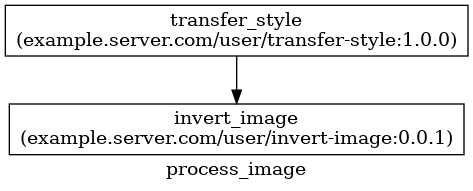

In [29]:
# pipeline.draw_dot(with_style=False)
pipeline.draw_dot(with_style=True)

Here is an example of how we could generate/draw a `networkx` graph. `with_style` is currently being ignored by `networkx` (should probably remove the arg) but I think that is probably best since I think we may use this library mainly for traversing the graph. Also, we could add the `metadata` info directly to the `networkx` nodes as attributes but this has not been implemented yet.

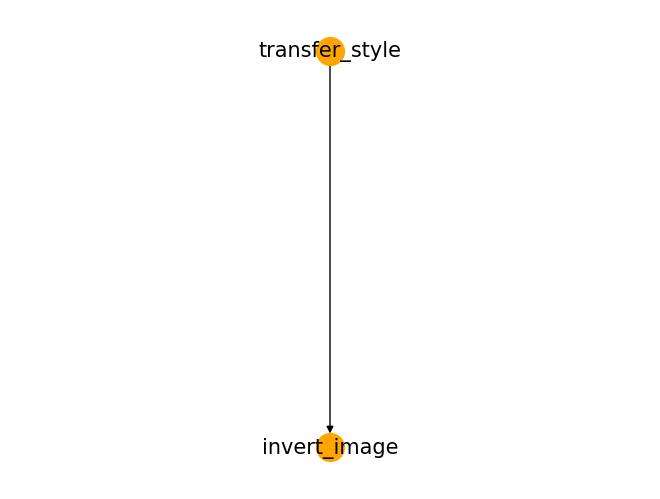

In [12]:
pipeline.draw_networkx(with_style=True)

Finally, we can save the `Pipeline`. This would in turn call save on all the nodes defined in the pipeline and then call `_to_yaml` before saving the pipeline itself. Since we saved them previously and they are up to date, `orcapod` will simply skip saving the nodes.

In [30]:
store.save_pipeline(pipeline=pipeline)

Skip saving pod model since `16749d5e4bd41d8cc6bcd1d7eeab1a4e35e75a4e558842eba4c10d3d36e9c756` exists.
Skip saving pod model since `1939246564aa830da5aedec147701fb2930775fdd3778bdc1b5cf67bd8ae2932` exists.


Below is a another example of how this spec design allows for the generation of DOT figures simply by using the `graphviz` and `yq` system packages w/o orcapod. Supports including or excluding the style.

In [31]:
# !yq '"digraph{\(.definition)}"' ../.tmp/orcapod_model/pipeline/3e368bf36ccce94bd51432877251c90fe49d2bbfb44be0d4cce8d6e4c9a2f992/spec.yaml | dot -T svg > process_image.svg
!yq '"digraph{\(.definition)\n\(.style)}"' ../.tmp/orcapod_model/pipeline/3e368bf36ccce94bd51432877251c90fe49d2bbfb44be0d4cce8d6e4c9a2f992/spec.yaml | dot -T svg > process_image.svg

# PipelineJob

Now that we have a `Pipeline` defined, we can use it to prepare a new pipeline job to be run. I haven't yet implemented something to DEMO, however, we can review some of the ideas I had related to the user input for a pipeline job. 

Continuing from the style transfer example, we now can define the pipeline job to demonstrate how we could process a group of subjects and a group of styles.

> Note: Since we are now defining the actual computational pipeline we want to run, the following are the node rules:
> - allowed:
>   - `Input`
>   - `Mapper`
>   - `Pipeline`
> - not allowed:
>   - `Curator`
>   - `Pod`

Similarly as in `Pipeline`, we could specify the allowed nodes in 2 modes: inline definition or using `link`.

In [32]:
pipeline_job_input = f"""
class: pipeline_job
annotation:
  name: process_image_batch
  version: 0.2.0
  description: This pipeline job performs a style transfer + inverts the colors of a set of images.
definition: |
  {{subjects, styles}} -> cartesian -> process_image
metadata:
  subjects:
    spec:
      class: input
      ...
  styles:
    spec:
      class: input
      ...
  cartesian:
    spec:
      class: mapper
      ...
  process_image:
    spec:
      class: pipeline
      link:
        name: process_image
        version: 0.1.0
"""

### Clean up

In [33]:
shutil.rmtree(f"{store.directory()}/orcapod_model")